# Pendahuluan

# Import Library

In [ ]:
!pip install yahoofinancials
from yahoofinancials import YahooFinancials
import numpy as np
from sklearn.metrics import mean_squared_error
import pandas as pd
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
import math
import matplotlib.pyplot as plt
plt.style.use('seaborn')
from datetime import datetime

#For reproducability
from numpy.random import seed
seed(1)



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# load data download dari yahoo
df = pd.read_csv('/content/BBRI.JK.csv')
df.shape

(2733, 7)

In [ ]:
#importing libraries for dataframe and mathematical functions
import pandas as pd
from pandas import DataFrame
import numpy as np

#importing libraries for graphical representation
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,7)
plt.style.use('fivethirtyeight')
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
import seaborn as sns

#imported library for date,time variables
from datetime import datetime, timedelta

#importing libraries necessary for model creation
from statsmodels.tsa.arima_model import ARIMA                 #library for ARIMA model implementation
from statsmodels.tsa.statespace.sarimax import SARIMAX        #library for SARIMAX model implementation
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf #library imported for plotting ACG and PACF graphs
from statsmodels.tsa.stattools import adfuller                #library to compute with ADFuller test

#importing library for seasonal decomposition implementation
from statsmodels.tsa.seasonal import seasonal_decompose

from scipy import stats
import statsmodels.api as sm
from itertools import product

import warnings
warnings.filterwarnings('ignore')

In [ ]:
def Test_Stationarity(timeseries):
  result = adfuller(timeseries['Close'], autolag = 'AIC')
  print("Results of Dickey Fuller Test")
  print(f'Test Statistics: {result[0]}')
  print(f'p-value: {result[1]}')
  print(f'Number of lags used: {result[2]}')
  print(f'Number of observations used: {result[3]}')
  for key, value in result[4].items():
    print(f'critical value ({key}): {value}')

# Get Data

In [ ]:
# buat function 
def plot_predictions(test,predicted,symbol):
    plt.plot(test, color='red',label=f'Real {symbol} Stock Price')
    plt.plot(predicted, color='blue',label=f'Predicted {symbol} Stock Price')
    plt.title(f'{symbol} Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel(f'{symbol} Stock Price')
    plt.legend()
    plt.show()

def plot_return_predictions(test,predicted,symbol):
    plt.plot(test, color='red',label=f'Real {symbol} Stock Price Returns')
    plt.plot(predicted, color='blue',label=f'Predicted {symbol} Stock Price Return')
    plt.title(f'{symbol} Stock Return Prediction')
    plt.xlabel('Time')
    plt.ylabel(f'{symbol} Stock Price Returns')
    plt.legend()
    plt.show()
    
def return_rmse(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))
    return rmse

def get_ticker_data(ticker: str, param_start_date, param_end_date) -> dict:
    raw_data = YahooFinancials(ticker)
    return raw_data.get_historical_price_data(param_start_date, param_end_date, "daily").copy()

def fetch_ticker_data(ticker: str, start_date, end_date) -> pd.DataFrame:
    date_range = pd.bdate_range(start=start_date, end=end_date)
    values = pd.DataFrame({'Date': date_range})
    values['Date'] = pd.to_datetime(values['Date'])
    raw_data = get_ticker_data(ticker, start_date, end_date)
    return pd.DataFrame(raw_data[ticker]["prices"])[['date', 'open', 'high', 'low', 'adjclose', 'volume']]

def shift(xs, n):
    e = np.empty_like(xs)
    if n >= 0:
        e[:n] = np.nan
        e[n:] = xs[:-n]
    else:
        e[n:] = np.nan
        e[:n] = xs[-n:]
    return e



In [ ]:
# # Choose a stock symbol
symbol_to_fetch = 'BBRI.JK'

# Choose a date range
start_date = '2012-01-01'
end_date = '2022-12-31'

# Get Stock Price Data
stock = fetch_ticker_data(symbol_to_fetch, start_date, end_date)
stock.columns = ['DateTime', 'Open', 'High', 'Low', 'Close', 'Volume']
stock = stock.fillna(method="ffill", axis=0)
stock = stock.fillna(method="bfill", axis=0)
#stock = stock.set_index('DateTime')

stock['Symbol'] = symbol_to_fetch
stock.tail()

#save a copy for later testing
original_stock = stock
original_symbol = symbol_to_fetch
# show dataset
stock['Close'].tail()

2728    4639.029785
2729    4582.570801
2730    4535.521484
2731    4582.570801
2732    4648.439453
Name: Close, dtype: float64

In [ ]:
# Choose a stock symbol
symbol_to_fetch = 'BBRI.JK'
# Choose a date range
start_date = str(datetime(2012, 1, 1).date())
end_date = str(datetime(2021, 12, 31).date())
# end_date = datetime.now().strftime('%Y-%m-%d')

# Preprocessing

In [ ]:
stockprice = stock.copy()

In [ ]:
stockprice.head(3)

,DateTime,Open,High,Low,Close,Volume,Symbol
0,1325469600,1360.0,1370.0,1350.0,953.869385,15835000.0,BBRI.JK
1,1325556000,1380.0,1390.0,1360.0,967.896729,81980000.0,BBRI.JK
2,1325642400,1390.0,1390.0,1370.0,974.910706,151180000.0,BBRI.JK


In [ ]:
stockprice.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2733 entries, 0 to 2732
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   DateTime  2733 non-null   int64  
 1   Open      2733 non-null   float64
 2   High      2733 non-null   float64
 3   Low       2733 non-null   float64
 4   Close     2733 non-null   float64
 5   Volume    2733 non-null   float64
 6   Symbol    2733 non-null   object 
dtypes: float64(5), int64(1), object(1)
memory usage: 149.6+ KB


In [ ]:
stockprice.isna().sum()

DateTime    0
Open        0
High        0
Low         0
Close       0
Volume      0
Symbol      0
dtype: int64

## Test Stasioner

In [ ]:
Test_Stationarity(stockprice)

Results of Dickey Fuller Test
Test Statistics: -0.6128715765321361
p-value: 0.8680469724573092
Number of lags used: 16
Number of observations used: 2716
critical value (1%): -3.432759974661461
critical value (5%): -2.862604751229049
critical value (10%): -2.5673368020035094


Seperti yang kita ketahui bahwa nilai p tidak boleh lebih besar dari 0,05 agar deret menjadi stasioner. Tetapi karena nilai p adalah 0,80 yang lebih besar dari ambang batas. Deret tersebut dapat dikatakan tidak stasioner.

In [ ]:
stockprice.isna().sum()

Open      1283
High      1283
Low       1283
Close     1283
Volume    1283
dtype: int64

In [ ]:
stockprice_month['Close_box'], lmbda = stats.boxcox(stockprice_month.Close)
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(stockprice_month.Close)[1])

Dickey–Fuller test: p=0.978531


In [ ]:
# Seasonal differentiation
stockprice_month['Close_diff'] = stockprice_month.Close_box - stockprice_month.Close_box.shift(12)
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(stockprice_month.Close_diff[12:])[1])

Dickey–Fuller test: p=0.191117


In [ ]:
stock.shape

(2733, 7)

In [ ]:
stockprice

,DateTime,Open,High,Low,Close,Volume,Symbol
0,1325469600,1360.0,1370.0,1350.0,953.869385,15835000.0,BBRI.JK
1,1325556000,1380.0,1390.0,1360.0,967.896729,81980000.0,BBRI.JK
2,1325642400,1390.0,1390.0,1370.0,974.910706,151180000.0,BBRI.JK
3,1325728800,1390.0,1400.0,1370.0,974.910706,134337500.0,BBRI.JK
4,1325815200,1380.0,1400.0,1370.0,967.896729,105145000.0,BBRI.JK
...,...,...,...,...,...,...,...
2728,1672020000,4900.0,4930.0,4890.0,4639.029785,43581100.0,BBRI.JK
2729,1672106400,4930.0,4950.0,4860.0,4582.570801,74123800.0,BBRI.JK
2730,1672192800,4870.0,4880.0,4810.0,4535.521484,117912500.0,BBRI.JK
2731,1672279200,4820.0,4870.0,4800.0,4582.570801,106690700.0,BBRI.JK


In [ ]:
stockprice.isna().sum()

DateTime    0
Open        0
High        0
Low         0
Close       0
Volume      0
Symbol      0
dtype: int64

Dickey–Fuller test: p=0.000000


<Figure size 1500x700 with 0 Axes>

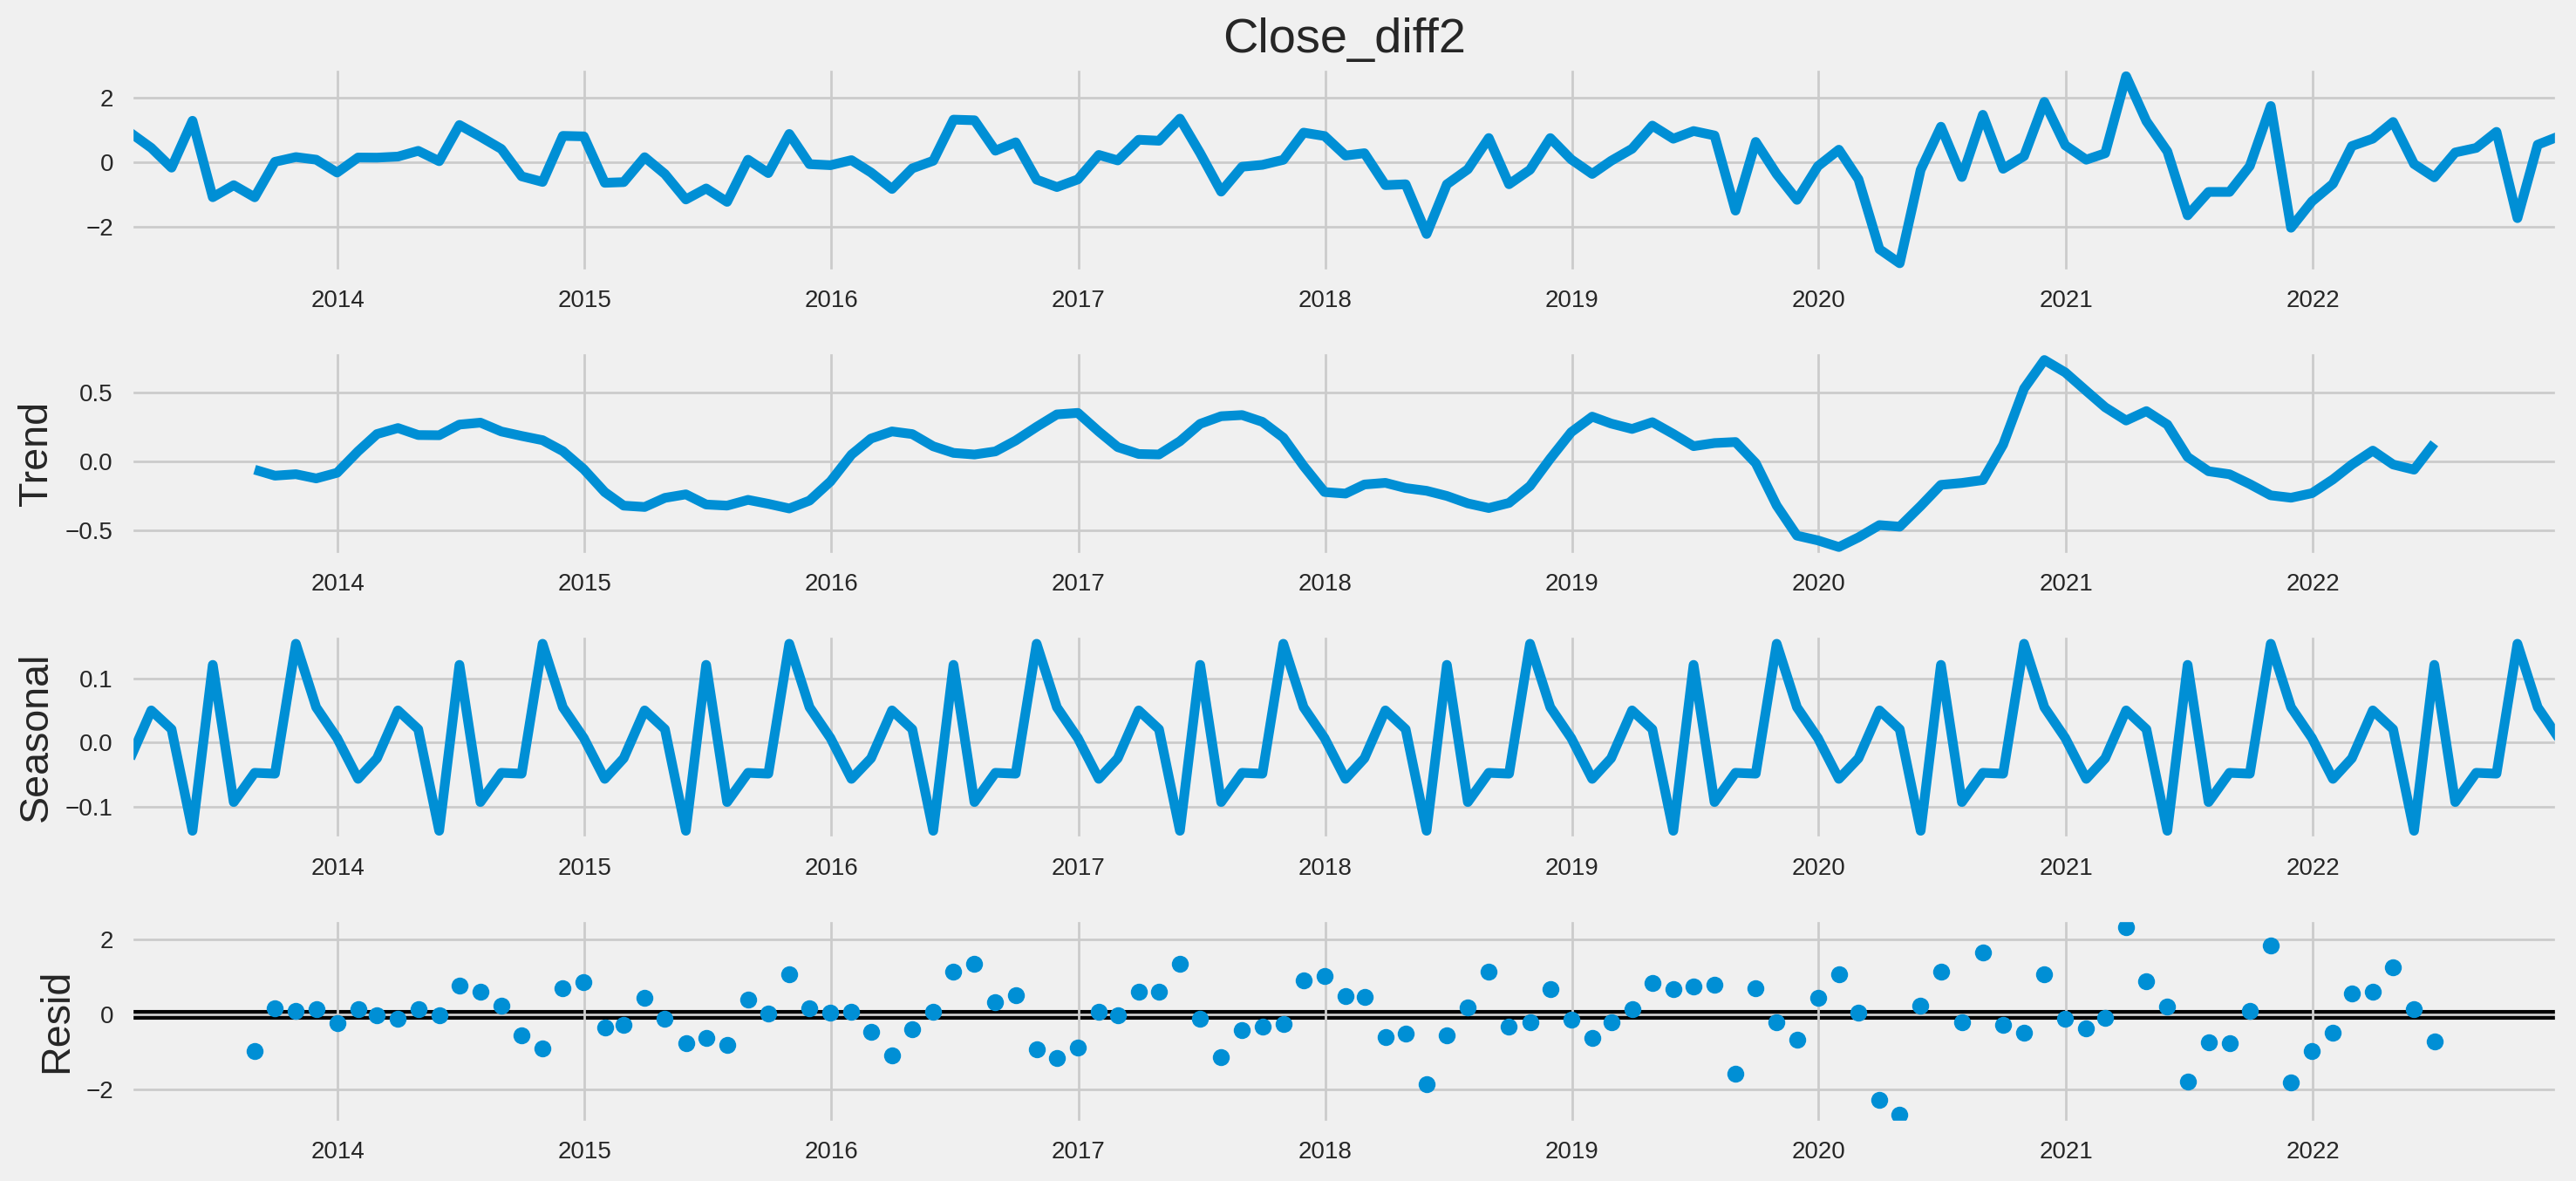

In [ ]:
# Regular differentiation
stockprice_month['Close_diff2'] = stockprice_month.Close_diff - stockprice_month.Close_diff.shift(1)
plt.figure(figsize=(15,7))

# STL-decomposition
sm.tsa.seasonal_decompose(stockprice_month.Close_diff2[12:]).plot()   
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(stockprice_month.Close_diff2[12:])[1])

plt.show()

## Analisis ACF PACF

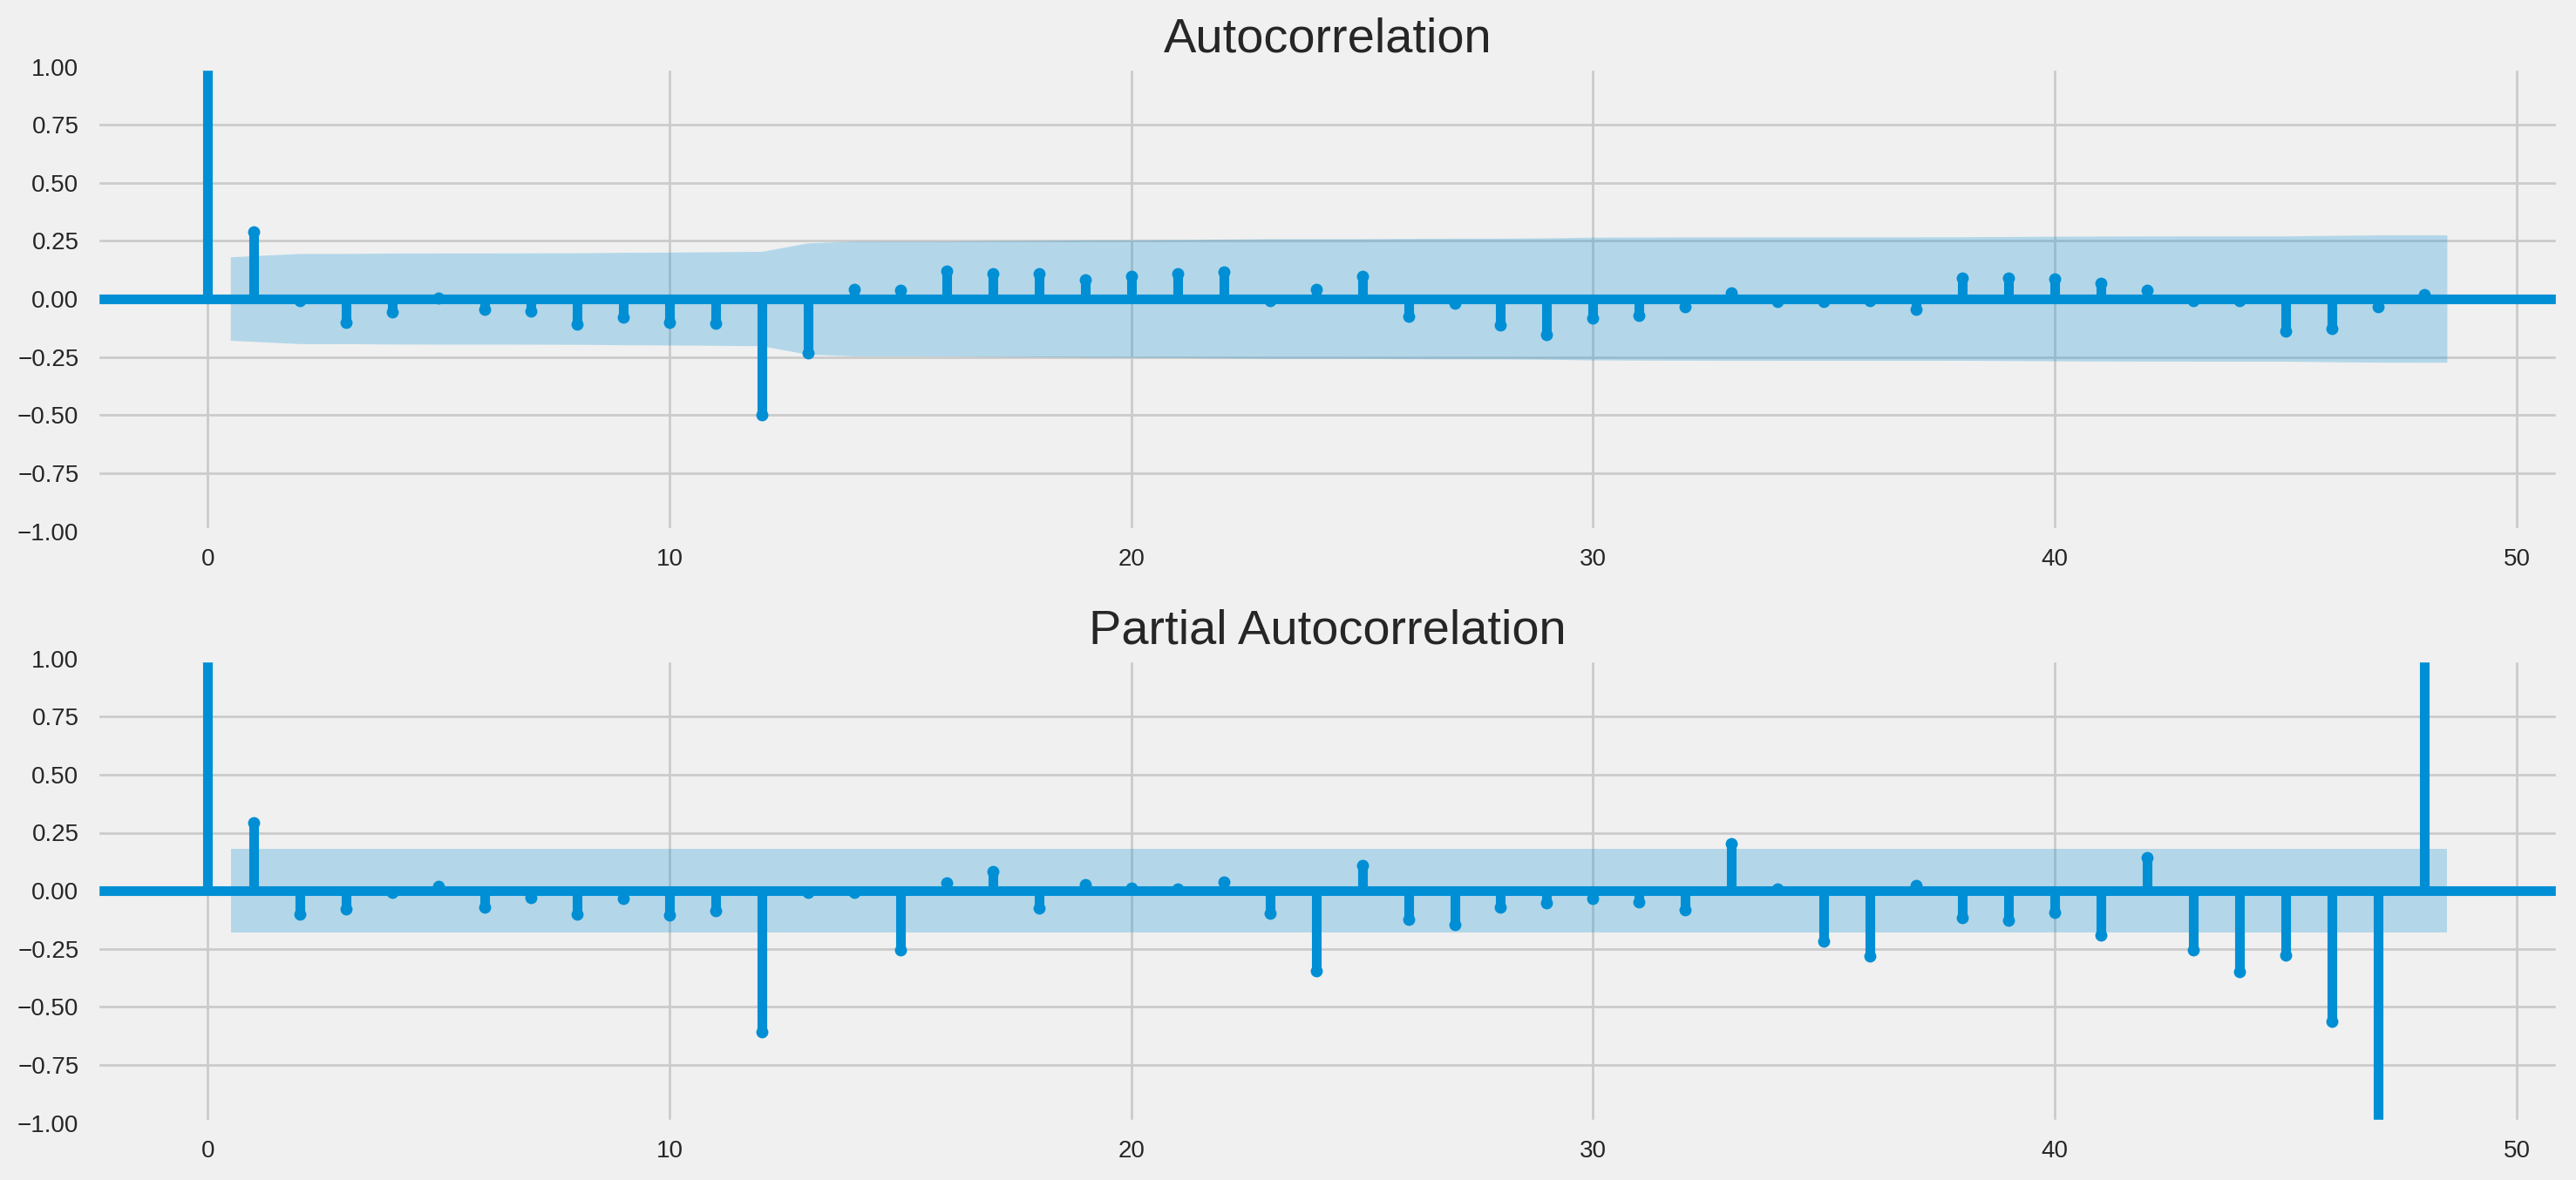

In [ ]:
# analisis ACF PACF
plt.figure(figsize=(15,7))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(stockprice_month.Close_diff2[13:].values.squeeze(), lags=48, ax=ax)
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(stockprice_month.Close_diff2[13:].values.squeeze(), lags=48, ax=ax)
plt.tight_layout()
plt.show()

In [ ]:
Qs = range(0, 2)
qs = range(0, 3)
Ps = range(0, 3)
ps = range(0, 3)
D=1
d=1
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)


54

In [ ]:
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')
for param in parameters_list:
    try:
        model=sm.tsa.statespace.SARIMAX(stockprice_month.Close_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

In [ ]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())
print(best_model.summary())

      parameters         aic
43  (2, 1, 0, 1)  249.731537
45  (2, 1, 1, 1)  250.774985
47  (2, 1, 2, 1)  250.787414
46  (2, 1, 2, 0)  251.799309
53  (2, 2, 2, 1)  254.064301
                                     SARIMAX Results                                      
Dep. Variable:                          Close_box   No. Observations:                  132
Model:             SARIMAX(2, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -119.866
Date:                            Sat, 20 May 2023   AIC                            249.732
Time:                                    07:41:22   BIC                            263.627
Sample:                                01-31-2012   HQIC                           255.374
                                     - 12-31-2022                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-------------------

Dickey–Fuller test:: p=0.000000


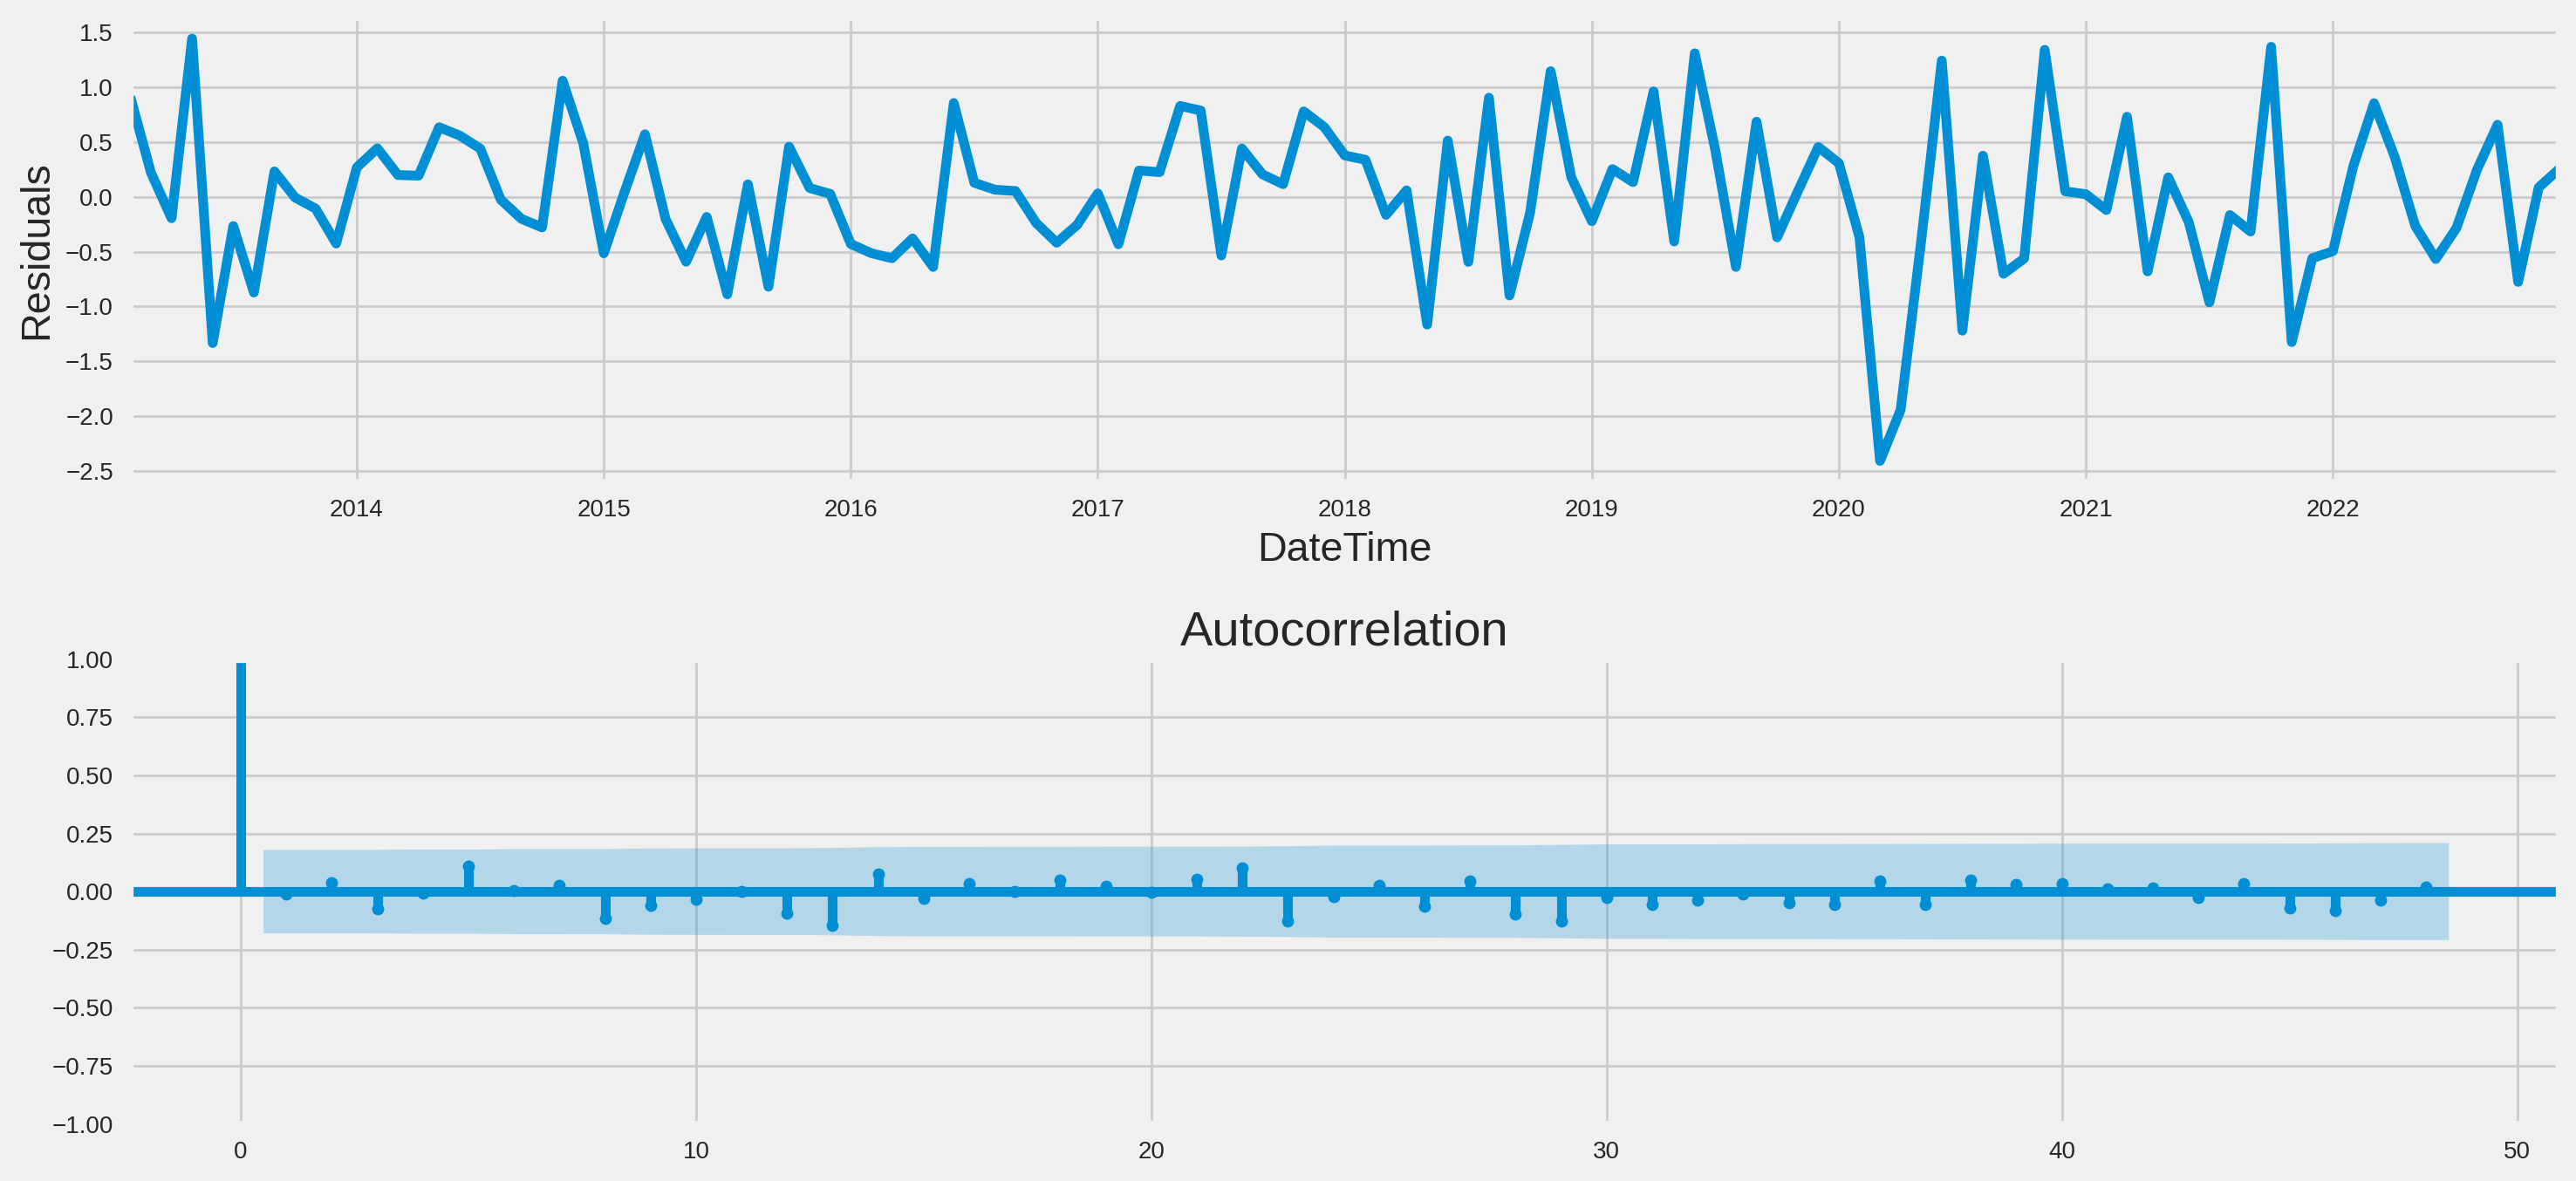

In [ ]:
# STL-decomposition
plt.figure(figsize=(15,7))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')
ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Dickey–Fuller test:: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

plt.tight_layout()
plt.show()

# Train Test Split

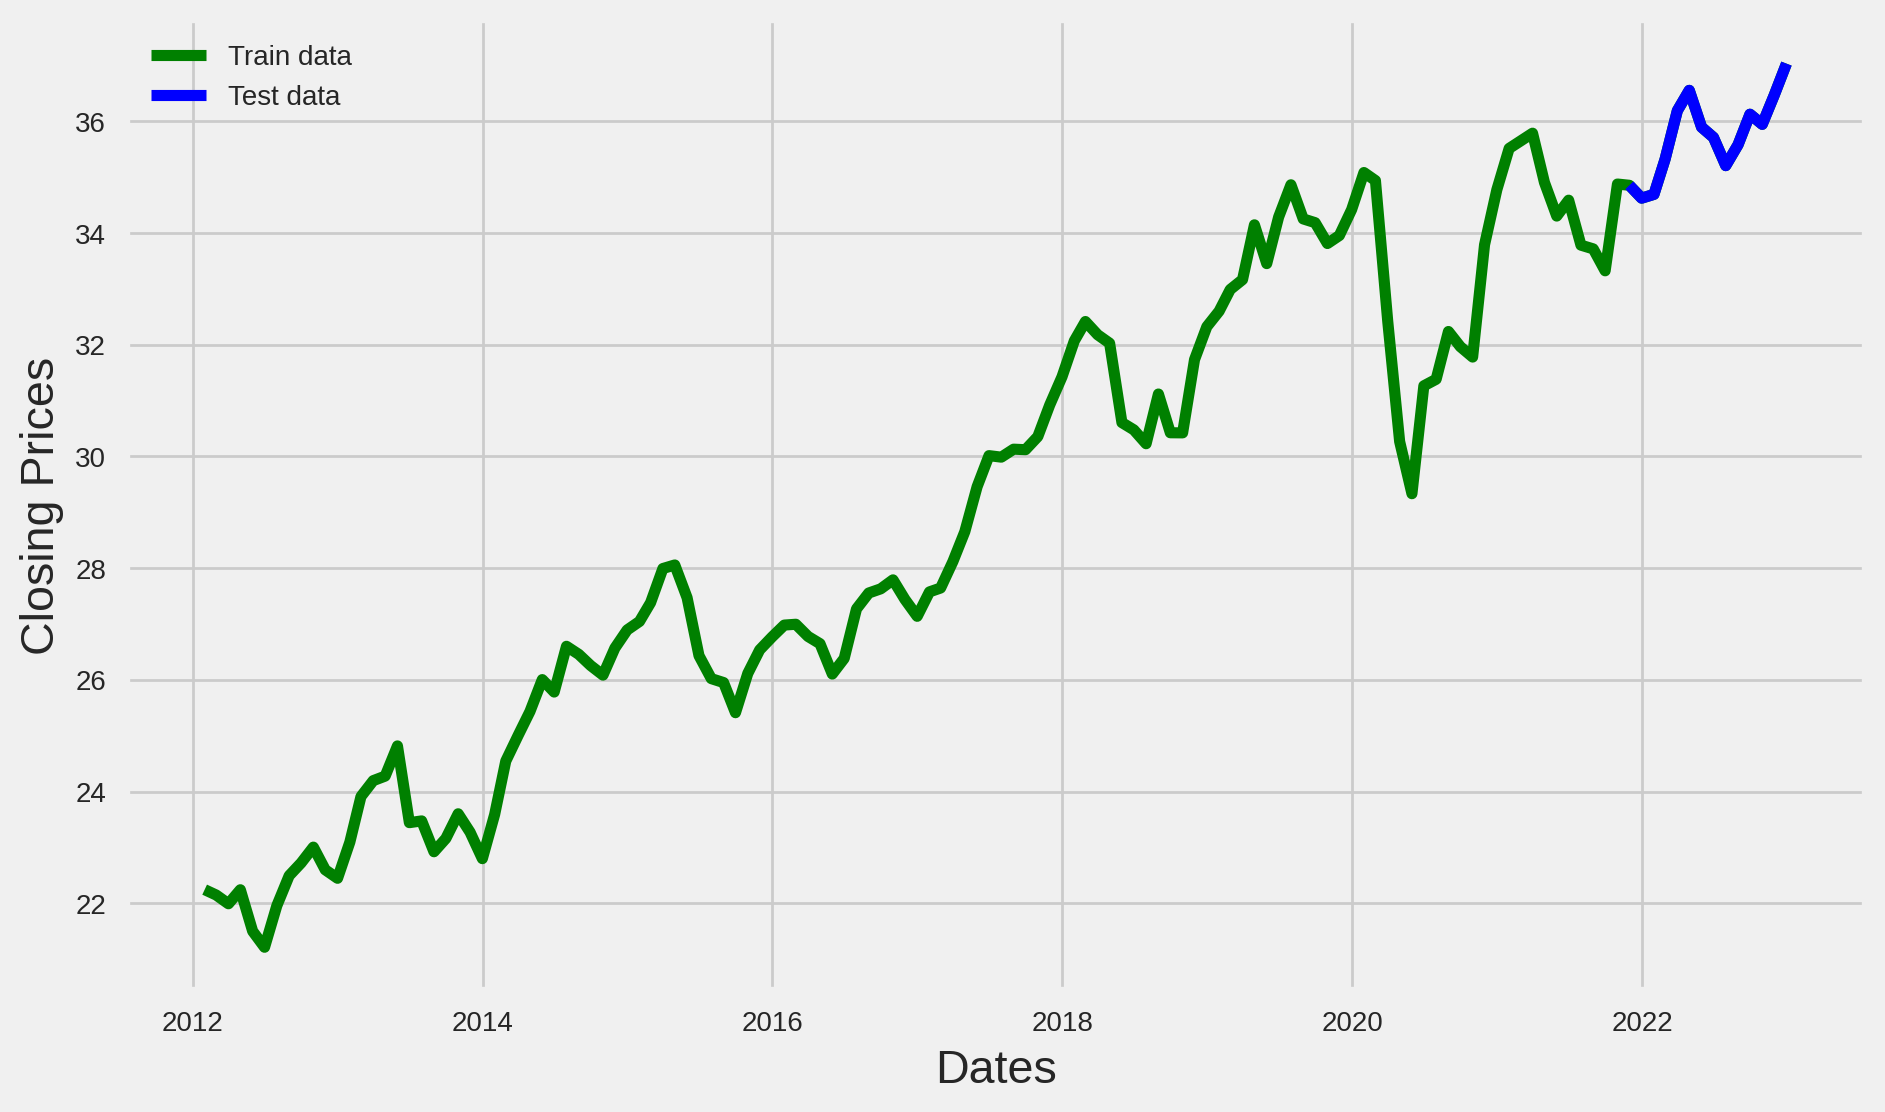

In [ ]:
train_data, test_data = stockprice_month.Close_box[3:int(len(stockprice_month.Close_box)*0.9)], stockprice_month.Close_box[int(len(stockprice_month.Close_box)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(stockprice_month.Close_box, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

# Modelling

In [ ]:
import pmdarima as pm
modelarima = sm.tsa.arima.ARIMA(train_data, order=(2,1,1))
model_fit = modelarima.fit()


In [ ]:
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:              Close_box   No. Observations:                  115
Model:                 ARIMA(2, 1, 1)   Log Likelihood                -112.721
Date:                Sat, 20 May 2023   AIC                            233.442
Time:                        07:42:35   BIC                            244.387
Sample:                    04-30-2012   HQIC                           237.884
                         - 10-31-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0650      0.227      4.685      0.000       0.619       1.511
ar.L2         -0.3039      0.088     -3.457      0.001      -0.476      -0.132
ma.L1         -0.7879      0.240     -3.280      0.0

In [ ]:
fc= model_fit.forecast(40, alpha=0.05)  # 95% conf
se= model_fit.forecast(40, alpha=0.05)
conf= model_fit.forecast(40, alpha=0.05)

# Evaluasi

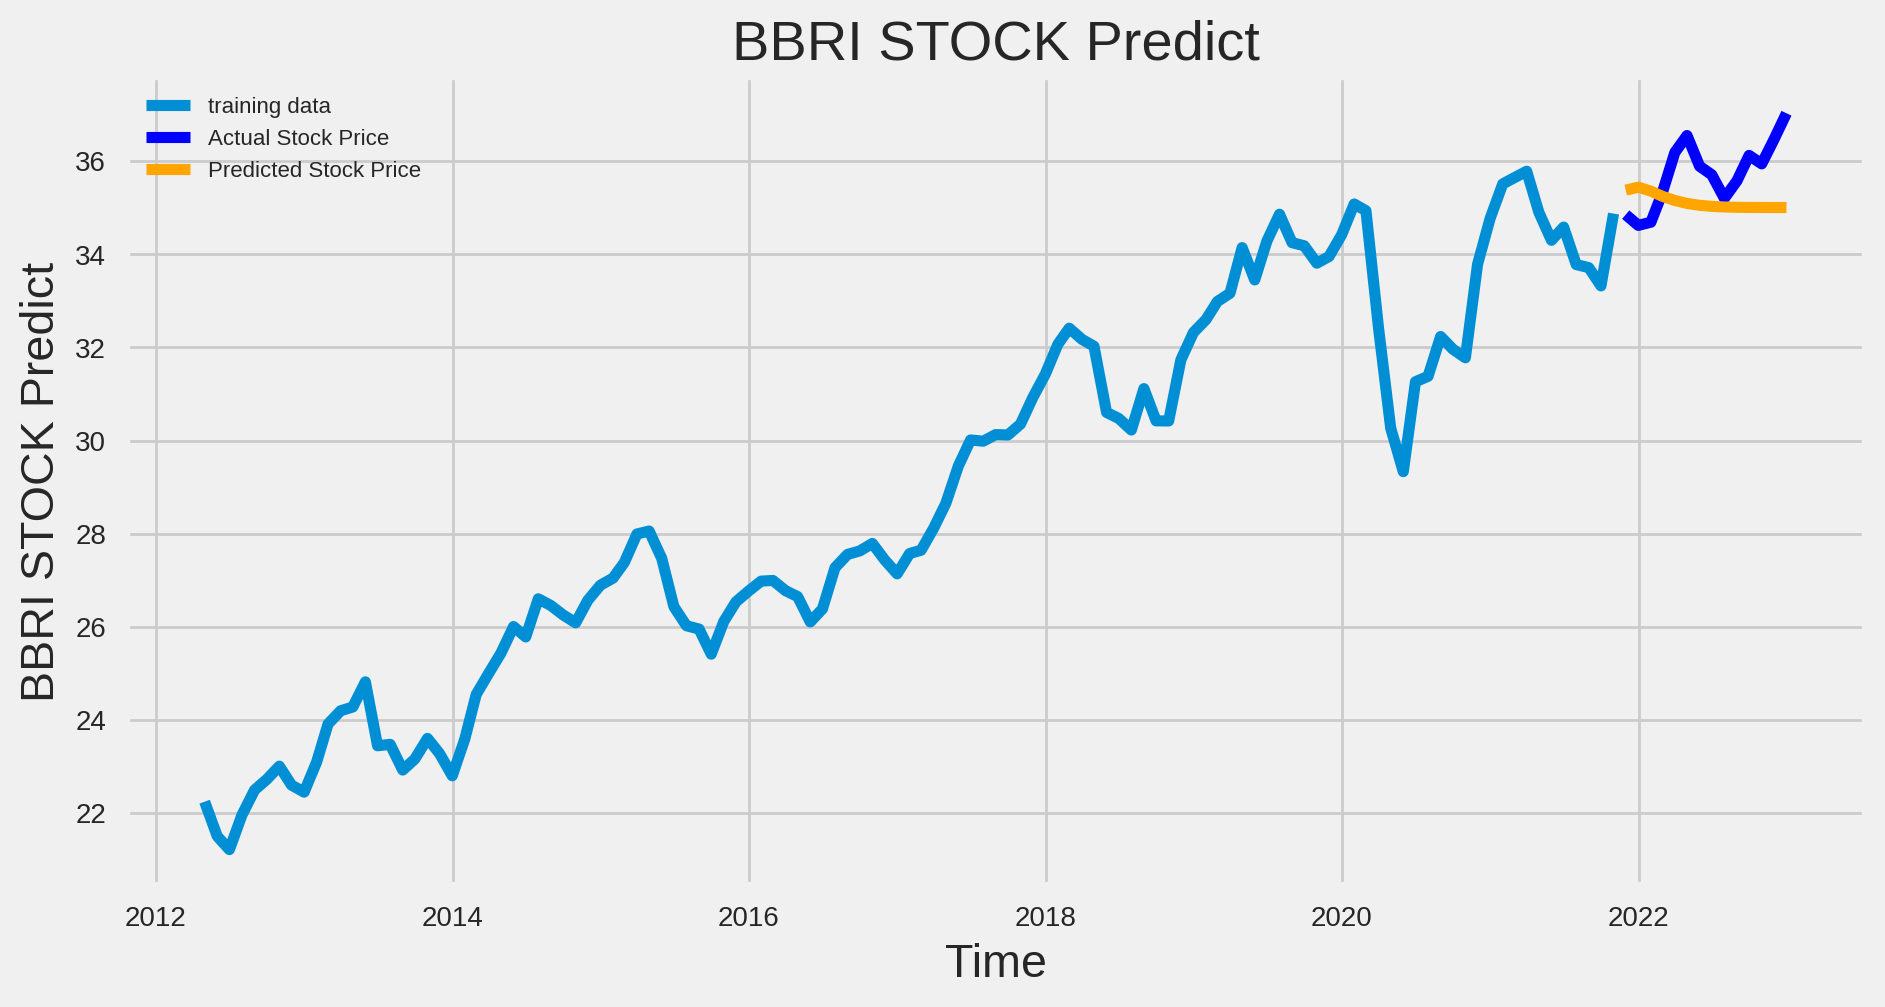

MAPE: 0.024557189471871316


In [ ]:
fc_series = pd.Series(fc, index=test_data.index)
#lower_series = pd.Series(conf[:, 0], index=test_data.index)
#upper_series = pd.Series(conf[:, 1], index=test_data.index)
# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training data')
plt.plot(test_data, color = 'blue', label='Actual Stock Price')
plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
#plt.fill_between(lower_series.index, lower_series, upper_series, 
#                 color='k', alpha=.10)
plt.title('BBRI STOCK Predict')
plt.xlabel('Time')
plt.ylabel('BBRI STOCK Predict')
plt.legend(loc='upper left', fontsize=8)
plt.show()

mape = np.mean(np.abs(fc - test_data)/np.abs(test_data))
print('MAPE: '+str(mape))

In [ ]:
mape = np.mean(np.abs(fc - test_data)/np.abs(test_data))
print('MAPE: '+str(mape))

MAPE: 0.024557189471871316


In [ ]:
print("MAPE arima = ",mape*100)

MAPE arima =  2.4557189471871315
